# Imports

In [1]:
import math
import serial
from threading import Thread
import time
import re

import pylab as pl
from IPython import display
import matplotlib.pyplot as plt
%matplotlib qt

In [2]:
# connect to the Serial
ser = serial.Serial('COM3', 9600)
time.sleep(2)

# Utils

In [3]:
def parse_serial(serial_msg):
    """
    Function to parse serial data to extract float values
    format 'x:19.34 y:23.01 z:-33.83' to x, y, z float values

    Args:
        - (str) string with format 'x:19.34 y:23.01 z:-33.83'
    Return:
        - (list) x, y, z float values
    """
    xyz_list = re.findall('[-+]?[0-9]*\.?[0-9]*', serial_msg)
    return [float(i) for i in filter(lambda item: item, xyz_list)]

In [4]:
def UpdateOrientation(ser):
    """
    Function to integration the x data from the Gyroscope
    and update the global variable x_orientation with the new value

    Args:
        - (serial.Serial) serial to get the gyroscope data
    """
    global x_orientation

    while True:
        serial_msg_bytes = ser.readline()
        serial_msg = serial_msg_bytes.decode()
        dx, dy, dz = parse_serial(serial_msg)
        
        # The gyroscope values are in degrees-per-second
        # divide each value by the number of samples per second
        dx_normalized = dx / gyroscope_sample_rate;

        # remove noise
        if(abs(dx_normalized) > 0.004):
            # update orientation
            x_orientation = x_orientation - dx_normalized*1.25
            x_orientation = x_orientation%360

# Update orientation in real time

In [29]:
# initialize x orientation
x_orientation = 0

# 119 got from Arduino with IMU.gyroscopeSampleRate();
gyroscope_sample_rate = 119

In [6]:
# run the thread to update the x orientation in real time
Thread(target=UpdateOrientation, args=(ser,)).start()

# Plot orientation in 2D

In [ ]:
while True:
    plt.clf()

    # plot origin in blue
    plt.scatter(0, 0, s=100, c='b')

    # find position of the end of the needle
    # 0.1 far from origin in direction of the orientation
    distance = 0.1
    x_orientation_rad = math.radians(x_orientation)
    x_pos = math.cos(x_orientation_rad)*distance
    y_pos = math.sin(x_orientation_rad)*distance

    # plot line between both position with circles
    plt.plot([0, x_pos], [0, y_pos], 'ro-')
    
    plt.xlim([-distance, distance])
    plt.ylim([-distance, distance])
    plt.pause(0.1)

# Get depth image

In [36]:
import cv2
import os.path
import numpy as np
from utils.eval import *
import urllib.request
import math
from tqdm import tqdm
import random

In [2]:
TFLITE_FILE_PATH = 'model/midas_v2_1_small.tflite'

if not os.path.isfile(TFLITE_FILE_PATH):
    tflite_model_url = "https://tfhub.dev/intel/lite-model/midas/v2_1_small/1/lite/1?lite-format=tflite"
    urllib.request.urlretrieve(tflite_model_url, TFLITE_FILE_PATH)

In [3]:
# Load TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path=TFLITE_FILE_PATH)
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

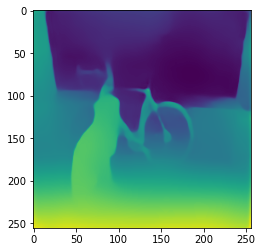

In [4]:
# Get input image
img = cv2.imread('images/dog.jpg')
rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# preprocess input image
input_data = preprocess_image(rgb_img, [256, 256])

# reshape data according to input_details
input_data = tf.transpose(input_data, [0, 2, 3, 1])

# Get result
interpreter.set_tensor(input_details[0]['index'], input_data)
interpreter.invoke()
output_data = tf.squeeze(interpreter.get_tensor(output_details[0]['index']), axis=0)

depth_map = output_data.numpy()
plt.imshow(depth_map)

In [5]:
tf.reduce_min(output_data), tf.reduce_max(output_data)

(<tf.Tensor: shape=(), dtype=float32, numpy=180.79759>,
 <tf.Tensor: shape=(), dtype=float32, numpy=883.7121>)

In [6]:
def get_rotation_matrix(orientation):
    rotation_matrix = np.array([[1, 0, 0],
                                [0, math.cos(orientation), -math.sin(orientation)],
                                [0, math.sin(orientation), math.cos(orientation)]])
    return rotation_matrix

In [7]:
unit_vector = np.array([0.1, 0.1, 0.1])

In [10]:
np.matmul(unit_vector, get_rotation_matrix(math.radians(30)))

array([0.1       , 0.13660254, 0.03660254])

In [49]:
image_width = 1280
image_height = 720

x_depth_rescale_factor = depth_map.shape[0] / image_width
y_depth_rescale_factor = depth_map.shape[1] / image_height

h_fov = math.radians(60)
v_fov = math.radians(40)

x_focal = image_width / (2*math.tan(h_fov/2))
y_focal = image_height / (2*math.tan(v_fov/2))

c_x = (0.5*image_width)
c_y = (0.5*image_height)

points_in_ned = []
for x in tqdm(range(image_width)):
    for y in range(image_height):

        # skip 90% of the points
        if random.randint(0, 999) >= 1:
            continue

        # get depth value
        x_depth_pos = int(x*x_depth_rescale_factor)
        y_depth_pos = int(y*y_depth_rescale_factor)
        depth_value = depth_map[x_depth_pos, y_depth_pos, 0]

        # get 3d vector
        x_point = depth_value * (x - c_x) / x_focal
        y_point = depth_value * (y - c_y) / y_focal
        point_3d_before_rotation = np.array([x_point, y_point, depth_value])

        # projection in function of the orientation
        point_3d_after_rotation = np.matmul(get_rotation_matrix(math.radians(0)), point_3d_before_rotation)
        points_in_ned.append(point_3d_after_rotation)

100%|████████████████████████████████████████████████████████████████████████████| 1280/1280 [00:00<00:00, 1630.67it/s]


In [50]:
len(points_in_ned)

926

100%|███████████████████████████████████████████████████████████████████████████████| 926/926 [00:01<00:00, 745.30it/s]


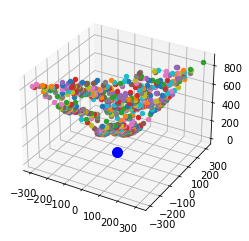

<Figure size 432x288 with 0 Axes>

In [51]:
fig = plt.figure()

ax = fig.add_subplot(111, projection='3d')

# plot origin in blue
ax.scatter(0, 0, s=100, c='b')

# find position of the end of the needle
# 0.1 far from origin in direction of the orientation
distance = 0.1
x_orientation_rad = math.radians(x_orientation)
x_pos = math.cos(x_orientation_rad)*distance
y_pos = math.sin(x_orientation_rad)*distance

# plot line between both position with circles
ax.quiver(0, 0, 0, x_pos, y_pos, 0,
          length=distance, normalize=True)

for i in tqdm(range(len(points_in_ned))):
    ax.scatter(points_in_ned[i][1], points_in_ned[i][1], points_in_ned[i][2])

'''ax.set_xlim(-distance, distance)
ax.set_ylim(-distance, distance)
ax.set_zlim(-distance, distance)'''

plt.show()
plt.pause(0.1)
plt.gcf().clear()

# Plot orientation in 3D

In [24]:
fig = plt.figure()

while True:
    ax = fig.add_subplot(111, projection='3d')

    # plot origin in blue
    ax.scatter(0, 0, s=100, c='b')

    # find position of the end of the needle
    # 0.1 far from origin in direction of the orientation
    distance = 0.1
    x_orientation_rad = math.radians(x_orientation)
    x_pos = math.cos(x_orientation_rad)*distance
    y_pos = math.sin(x_orientation_rad)*distance

    # plot line between both position with circles
    ax.quiver(0, 0, 0, x_pos, y_pos, 0,
              length=distance, normalize=True)

    ax.set_xlim(-distance, distance)
    ax.set_ylim(-distance, distance)
    ax.set_zlim(-distance, distance)
   
    plt.show()
    plt.pause(0.1)
    plt.gcf().clear()

KeyboardInterrupt: 